In [113]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [40, 10]
plt.rcParams['lines.markeredgewidth'] = 1 

%matplotlib inline

df = pd.read_csv("nsdata1.txt",  delimiter=r"\s+")

# After inspecting the data, I found that all three files contain different values 
# for the amount of passangers in each train.
# but all 3 files run on the same schedule (time-wise).

# The labels of the cities are:
AMSTERDAM = 1
ROTTERDAM = 2
ROOSENDAAL = 3
VLISSINGEN = 4

train_3 = [38, 163]

df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,700,740,4,58
1,2123,3,4,743,838,14,328
2,2127,1,2,648,755,47,340
3,2127,2,3,801,841,35,272
4,2127,3,4,843,938,19,181
5,2131,1,2,755,858,100,616
6,2131,2,3,902,941,52,396
7,2131,3,4,943,1038,27,270
8,2135,1,2,856,958,61,407
9,2135,2,3,1003,1043,41,364


In [114]:
def to_minutes_past_midnight(time: int) -> int:
    """Converts the time as used in the data-files to minutes past midnight.
    """

    assert type(time) == int, "The time must be an integer!"

    hours = time // 100
    minutes = time % 100

    return 60*hours + minutes

In [115]:
df['departure_time'] = df['departure_time'].map(lambda x: to_minutes_past_midnight(x))
df['arrival_time'] = df['arrival_time'].map(lambda x: to_minutes_past_midnight(x))

In [116]:
df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,420,460,4,58
1,2123,3,4,463,518,14,328
2,2127,1,2,408,475,47,340
3,2127,2,3,481,521,35,272
4,2127,3,4,523,578,19,181
5,2131,1,2,475,538,100,616
6,2131,2,3,542,581,52,396
7,2131,3,4,583,638,27,270
8,2135,1,2,536,598,61,407
9,2135,2,3,603,643,41,364


In [117]:
def total_passangers_at_t(passanger_type:str, row:pd.Series)->  int:
    """Amount of passagers of passanger_type in row.
    
    passanger_types = ['1', '2']
    """

    first = row[5]
    second = row[6] 

    return (passanger_type=='1')*first + (passanger_type=='2')*second 

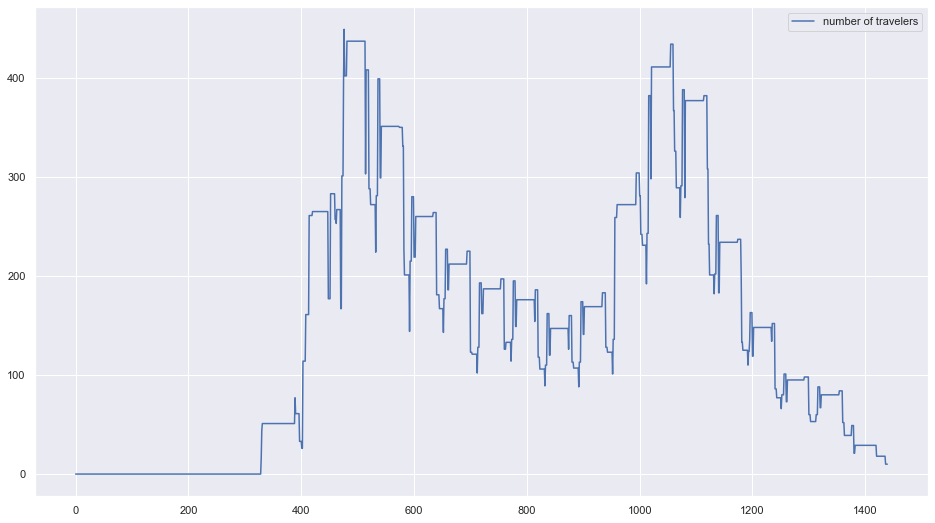

In [118]:
df_travelers_per_minute_first = pd.DataFrame(np.zeros((60*24, 1)))
df_travelers_per_minute_first.columns = ['number of travelers']

for index, row in df.iterrows():
    start = row[3]
    stop = row[4]
    tot = total_passangers_at_t('1', row)
    df_travelers_per_minute_first.loc[start:stop + 1, 'number of travelers'] += tot

df_travelers_per_minute_first.plot(kind='line', figsize=(16,9));

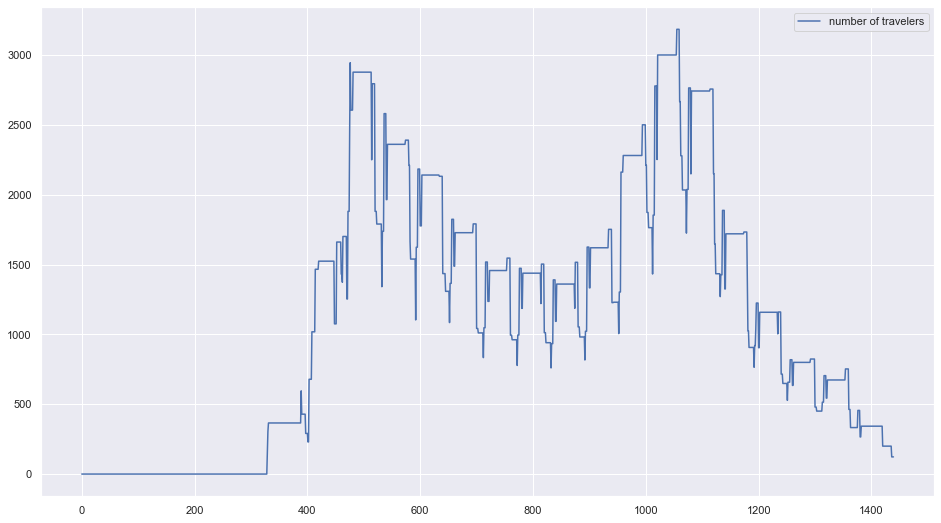

In [119]:
df_travelers_per_minute_second = pd.DataFrame(np.zeros((60*24, 1)))
df_travelers_per_minute_second.columns = ['number of travelers']

for index, row in df.iterrows():
    start = row[3]
    stop = row[4]
    tot = total_passangers_at_t('2', row)
    df_travelers_per_minute_second.loc[start:stop + 1, 'number of travelers'] += tot

df_travelers_per_minute_second.plot(kind='line', figsize=(16,9));

In [120]:
trains = dict()

for index, row in df.iterrows():
    if row[0] in trains:
        trains[row[0]] = pd.concat([trains[row[0]], pd.DataFrame(row[1:]).T])
    else:
        trains[row[0]] = pd.DataFrame(row[1:]).T

In [121]:
import itertools
colors = ['b', 'r', 'k', 'g', 'm', 'c']
color_cycle = itertools.cycle(colors)

class Train:
    def __init__(self, train_number: int, schedule: pd.DataFrame, ax:plt.Axes) -> None:
        """Create train object based on the train number and its schedule.
        """
        
        self.ax = ax
        self.train_number = train_number
        self._schedule = schedule
        df = pd.DataFrame()
        df['time'] = pd.concat([schedule['departure_time'], schedule['arrival_time']])
        df['place'] = pd.concat([schedule['from'], schedule['to']])
        self.schedule = df.sort_values(by='time').reset_index()


    def plot(self) -> None:
        """Plot the space time graph of the train line
        """
        col = next(color_cycle)

        ax=self.ax
            
        self.schedule.plot(kind='line', x='time', y='place', ax=ax, color=col) 
         
        for index, row in self._schedule.iterrows():
            offset_t = 2
            offset_p = -0.1
            place = (row[0] + row[1])/2 + offset_p
            time = (row[2] + row[3])/2 + offset_t

            ax.text(time, place, f'    first: {row[4]}\nsecond: {row[5]}')


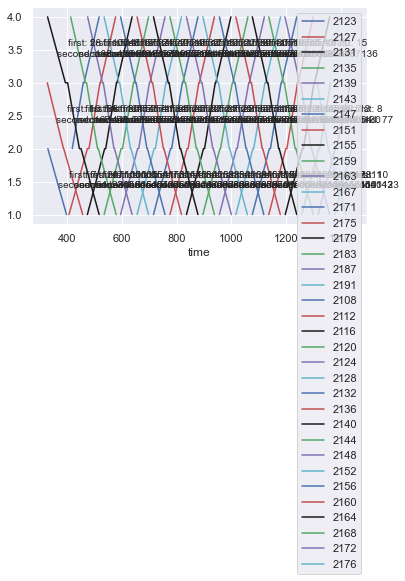

In [122]:
class VisualizeSchedule:
    def __init__(self, trains_to_visualize: dict) -> None:
        """Setup the schedule that needs to be visualized.
        """

        self.trains = trains_to_visualize

    def visualize(self) -> None:
        """Show the space-time plot of the train schedule.
        """

        ax = plt.gca()

        for key, value in self.trains.items():
            train = Train(key, value, ax)
            train.plot()
            plt.legend(self.trains.keys())

viz = VisualizeSchedule(trains)
viz.visualize()